# Citation Needed? Automatically Detecting Sentences from Computing Research Papers that Need Citations
Author: Nicholas Vincent, Northwestern University

email: nickvincent@u.northwestern.edu | web: [www.nickmvincent.com](http://www.nickmvincent.com)

Prof. Doug Downey's EECS349 course, final project

## Abstract: 
The scientific paper is the primary artifact produced by scientists of every discipline. Within a scientific paper, citations are incredibly valuable: they help connect a paper to the surrounding literature, provide evidence for claims, and empower a single PDF (often with less than 10 pages) to “stand on the shoulders of giants” by referencing prior work. However, language is ambiguous, and it may not always be trivial to decide whether a certain sentence should include a citation or not.  Therefore, it may be valuable for an author or reviewer to be able to quickly identify whether a sentence should include a citation or not. We implement and test a variety of machine learning classifiers that attempt to solve this task.

In this work, we explore a variety of approaches to classification,  (1) using word count vectorization alongside textual metadata with traditional classification techniques (Naive Bayes Classifier, Decision Trees, Support Vector Classifier, etc.) and (2) using deep learning techniques: recurrent neural networks (RNN) and long short-term memory (LSTM). Using a dataset with 6022 examples (85% negative), we see that support vector machine approaches provide a good balance of performance and quick training (reaching X AUROC with very quick training). Finally, using a larger dataset with 32,228 examples, we find that after tuning hyperparameters we can train a classifer with 85% recall and 40% precision (accuracy is 89%). This performance should be adequate to make this classifier useful as a "machine assistant" for authors or reviewers of academic papers.

## Organization of this Notebook
The main content of this notebook is organized based on the project guidelines for EECS349. At the end of the notebook is an appendix which goes into greater details about project details that are not specifically related to machine learning (e.g. details about the data cleaning, various examples of our dataset).

The following sections are:
1. Methods: Dataset
2. Methods: Overview of Features and Classification Approaches
3. Results
4. Future Work

An [appendix](/appendix) is included in a separate page. While not part of the official project submission, the appendix includes a variety of minor details that may be interesting and helpful (or not) to readers.

## Methods: Dataset
#### Data Aquisition
We generated all training and test data by downloading computing papers as PDF files and converting them to text (detailed below). Each text file was processed so as to split the text into sentences, identify all the sentences with citations, and then strip out the evidence of the citations (e.g. bracketed numbers like "[1]") so the data could be fairly for training. The full data pre-processing steps are explained in the Appendix.

First we used a small dataset composed of X papers. This dataset included 6022 different sentences and 11% (X) had citations. The papers for this dataset came exclusively from the PSA Research Group (the author's research lab), so we use this data when referring to example sentences. We refer to this dataset as the "psa_research dataset" in code and file organization. This is the dataset we did most of experiments with.

The second dataset was produced by downloading the full Proceedings of the 2018 CHI Conference on Human Factors in Computing Systems (CHI 2018), made available through the [ACM Digital Library]() (CITE) From this set of over 600 papers, we used 100 papers, which allowed the full training and testing process could be performed on a single laptop. This is the dataset we used for selecting a "best" model.


## Methods: Overview of Features and Classification Approaches Used

### Initial Approach
For our first set of classification approaches, we followed a simple strategy to turn sentences into features. We vectorized each sentence using a term frequency-inverse document frequency (Tf-Idf) approach, and then computed additional "hand-crafted" features to account for some aspects of text that are not captured by word counting: number of characters in the sentence and boolean variables indicating whether each sentence has any digit characters, has a comma character, has a quote character, and has an uppercase character after the first character.

Tf-Idf details: For the large dataset, we limited the bag-of-words vocabulary size to the 10,000 most frequent words to avoid memory issues. For all datasets, we included stop-words (as removing them just lowered performance) and stripped accents.

Then, we performed a variety of runs with statistical test feathe ture selection to reduce dimensionality of our feature space (sklearn's SelectKBest with ANOVA F-value, see [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). We tried reducing the max number of features to:
50,100,500,1000,2000,3000,4000,5000

Using these sets of features, we tested a variety of classifiers (using sklearn implementations, with default parameters unless otherwise noted).
1. Logistic Regression (using C Values of 0.1, 1, and 10, 100)
2. Linear Support Vector Classifier (using C values of 0.1, 1, and 10, 100)
3. Decision Tree
4. Gaussian Naive Bayes
5. K-Nearest Neighbors (3 neighbors)

### Deep Learning
We tested two different deep learning approaches for classification as well. Both were implemented using Tensorflow.

First, we tried to use a character-level RNN (features were character embeddings) trained for language modeling to perform classifications by adding our labels as tokens at the end of the sentence (e.g. "this is negative example.\`\`0 And this is a positive examples.\`\`1" - see code for more details) and predicted these tokens. The code for this implementation was a modified fork of this MIT-licensed Github repo: https://github.com/crazydonkey200/tensorflow-char-rnn. This approach was a bit of a hack (turning a language model into a classifier without changing the actual network or training).

Second, we trained a simple neural network using Tensorflow's DNNClassifier Estimator. For this classifier, we used the 250-dimension Wiki-word word embeddings, which are pre-trained on the Wikipedia corpus and available with Tensorflow. We tried a few network architectures with 1, 2, and 3 hidden layers. The reported results used 2 hidden layers, with 250 units then 100 units, with dropout probability of 0.1. The code for this implementation was a modified version of this CC-3.0 tutorial in the Tensorflow docs: https://www.tensorflow.org/tutorials/text_classification_with_tf_hub.

### A note on software and hardware used
As mentioned above, all our deep learning implementations used Tensorflow and all other machine learning implementations used sklearn. While we used multiple machines (including Google Cloud Platform) throughout experiments, all our reported results were run from the same machine, a Dell XPS 13 64-bit Windows machine with Intel i7-6560U CPU @ 2.20 GHZ and no GPU. This allowed us to directly compare the time taken of various methods.

## Results
### Metrics and other Considerations
For all our experiments, we decided to focus on performance metrics beyond accuracy, especially given the imbalanced class labels. Specifically, we chose to use area under the receiver operator characteristic curve (AUROC) when initially comparing models with the small dataset (as we were interested in having a model with strong discriminative power), and then to focus on the precision-recall curves for the large dataset to try to achieve a good precision-recall balance for users. The use case we considered was an academic who is writing a paper or reviewing a paper and wants to quickly use our tool to check for any sentences that might need citations. Under this model, the user likely wants to emphasize recall over precision: because most sentences do not have citations, if the model identifies all the sentences that do have citations, the user can quickly eliminate the false positives with their human judgment. Therefore, we decided to aim for a model that had the best precision when recall was over 80%.

Given that academics are often very busy, come from a variety of different fields and disciplines, often like to run their own software, and often work with limited computing resources, we also wanted to emphasize models that train quickly, test quickly, and run on a laptop, so that users could realistically train their own personal model. That being said, we still did consider the performance of slower and costlier approaches (e.g. deep learning, nearest neighbors) in case performance was vastly improved.

### Comparing model performance for the `psa_research` dataset
We were unable to get a language modeling small (2 hidden layers) character-level RNN or LSTM model to discriminate between sentences types - typically the AUROC was around 0.5. Additionally, given the comparatively slow training times (about 4 minutes per epoch for LSTM) *and* slow testing times (1.5 minutes to evaluate 20% of the small dataset), we decided to remove this model from contention.

Below, the 3 stacked heatmaps in Figure 1 show the AUROC, accuracy, and test time for each of our experiments on the smaller `psa_research` dataset. In Figure 2, the best accuracy and AUROC for each type of model is shown. We found that SVM, logistic regression, DNN, and Naive Bayes all provided good accuracy, but SVM and logistic regression provided the best AUROC. Overall, the best classifer was a linear SVM classifer with C=0.1 and the best 2000 features selected, which provided . Based on these results, we focused on SVM and logistic regression when examing precision-recall curves for the larger dataset.


In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('results/psa_research/result_dataframe.csv')
dnn_df = pd.concat([pd.read_csv('results/psa_research/dnn_best_roc_auc.csv'), pd.read_csv('results/psa_research/dnn_best_accuracy.csv')])
#dnn_df['max_features'] = 4000
df = pd.concat([df, dnn_df])

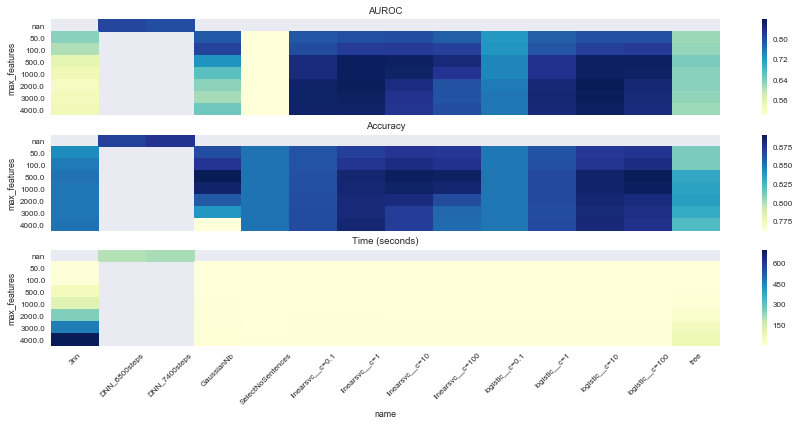

In [56]:
fig, axes = plt.subplots(nrows=3, figsize=(15,6))

ax = sns.heatmap(df.pivot('max_features', 'name', 'roc_auc'), ax=axes[0], cmap="YlGnBu")
ax.set_title('AUROC')
ax.get_xaxis().set_visible(False)
ax = sns.heatmap(df.pivot('max_features', 'name', 'accuracy'), ax=axes[1], cmap="YlGnBu")
ax.set_title('Accuracy')
ax.get_xaxis().set_visible(False)
ax = sns.heatmap(df.pivot('max_features', 'name', 'time'), ax=axes[2], cmap="YlGnBu")
ax.set_title('Time (seconds)')

plt.xticks(rotation=45)
plt.show()

_Figure 1_ - AUROC (left) and Accuracy (right) are plotted for a our experimental runs, with varying number of max features, models, and model hyperparameters. We see that in general, linear support vector classifier and logistic regression perform very well.

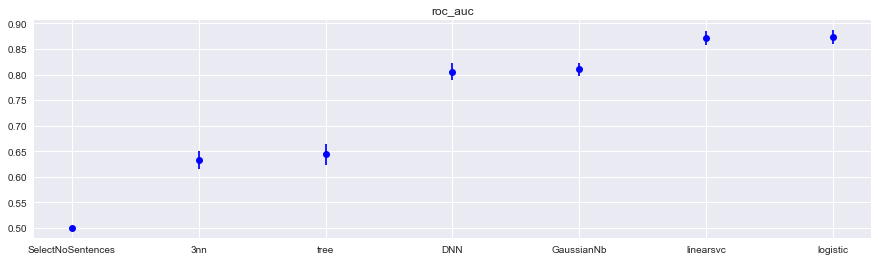

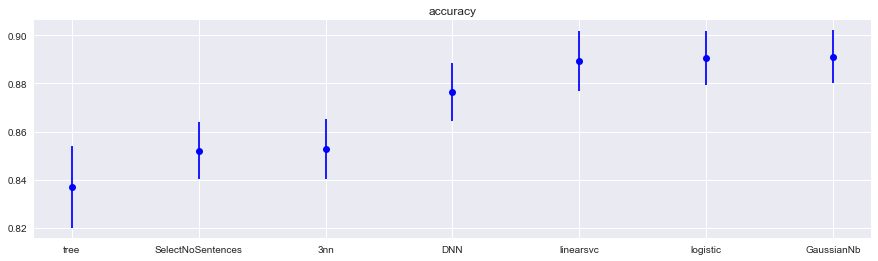

In [57]:
for score in ['roc_auc', 'accuracy']:
    algo_name_to_max = {}
    algo_name_to_std = {}
    for algo_name in list(set(df.algo_name)):
        algo_name_to_max[algo_name] = df[df.algo_name == algo_name][score].max()
        algo_name_to_std[algo_name] = df[score + '_std'].iloc[df[df.algo_name == algo_name][score].idxmax()]
    lists = sorted(algo_name_to_max.items(), key=lambda t: t[1])
    x, y = zip(*lists)
    yerr = [algo_name_to_std[key] for key in x]
    sns.set()
    plt.figure(figsize=(15,4))
    plt.errorbar(range(len(y)), y, yerr=yerr, fmt='bo')
    plt.xticks(range(len(y)), x)
    plt.title(score)
plt.show()

### Precision-recall with the `chi_2018` dataset
Focusing on logstic regression and SVM for the larger `chi_2018` dataset, we found a variety of hyperparameter choices achieved "useable" performance. Figure 3 shows precision-recall curves for our experiments on this larger dataset. Qualitatively, we that logistic regression and SVM both provide reasonable precision recall for larger choices of C when using around 1000-3000 features. Finally, we see that the "best" model, logistic regression with c=10 and 3000 features used, which achieved 0.878 AUROC gets 0.385 precision at 0.75 recall. In other words, users can expect a classifier weighted appropriately to identify 75% of all the sentences that might need citations and only 6 of 10 will be erroneous. This performance should be adequate to help authors and reviewers without causing the user to lose more time than might gain from using the tool.

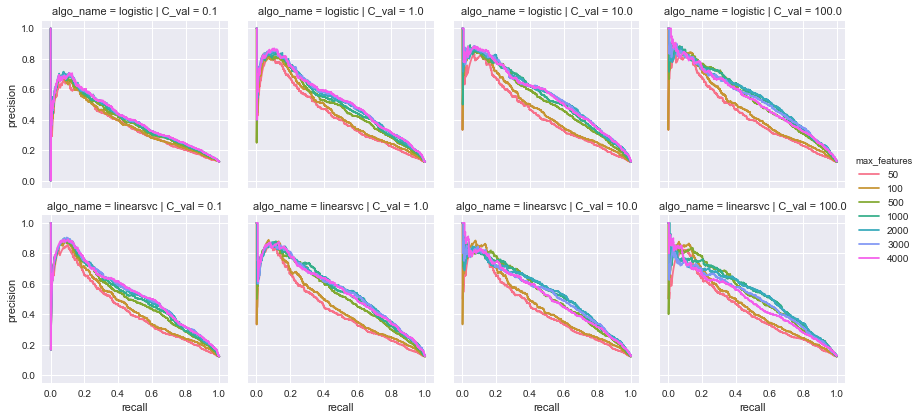

In [58]:
pr_df = pd.read_csv('results/chi_2018/precision_recall_dataframe.csv')
g = sns.FacetGrid(
    data=pr_df[(pr_df.algo_name == 'logistic') | (pr_df.algo_name == 'linearsvc')],
    row='algo_name', col='C_val',
    hue='max_features',
    #size=6
)
g = (g.map(plt.plot, 'recall', 'precision').add_legend())
plt.show()

_Figure 3_ - Precision-recall curves for logistic and SVM classifiers on the `chi_2018` dataset. Precision is shown on the y-axis and recall on the x-axis. Color denotes different choices for number of features to use, and each column shows a different choice of model parameter C.

## Future Work
While we focused on testing models that were small and quick to train, an interesting next step would be to try to build an extremely general model, incorporating text from across academic disciplines. This would require substantially more infrastructure and resources. It would be interesting to see how deep learning methods compare to other methods when using orders of magnitude more data (and, by extension less similar data).

Additionally, if user tests suggest that performance of our classifers are unsatisfactory, it may be possible to tweak our implementation to improve overall performance, perhaps through additional hand-crafted features designed by academics familiar with a particular field's writing trends, or through a more comprehensive hyperparameter search. In particular, although our exploration of deep learning approaches did not prove too fruitful, future work could explore different network structures and more exhaustive hyperparameter search (e.g. adding layers, trying different dropouts values, chaining networks).

0.0    211017
1.0     31422
Name: has_citation, dtype: int64


===
Example sentences without citations:
(no citation) how to join these lumber boards is essential to woodworking.








Guided by this prior work, we conducted a study to answer this overarching question: How does socioeconomic context shape caregivers' perceptions and use of current PA tracking tools?
(no citation) Our system was more accurate on fully incorrect SPSes (57% were "Accurate") than partially incorrect SPSes (36% were "Accurate").


INTRODUCTION Electronic textile technology enables people to create expressive, interactive, and functional textile artifacts for both playful and serious applications.
(no citation) In the long-answer category, recordings coded as Definition made up 7.63%.
(no citation) Clickstream and in-video dropout data are passively collected in that the data is naturally collected regardless of learners' intention.
(no citation) Our results (Tab.
(no citation) Publication date: January 2017.








Figure 2.
(no citation) are more correlated with t


===
Example sentences with citations:
Raw text: These are questions of experience, politics and human values [11,19,79].
1.0
Processed text: These are questions of experience, politics and human values.


Distribution of Head and Gaze Angles We measured the 3D head pose by fitting a generic 3D face model to the detected facial landmarks, and transformed the onscreen gaze location to the 3D direction vector in the camera coordinate system as in [3].
1.0


Distribution of Head and Gaze Angles We measured the 3D head pose by fitting a generic 3D face model to the detected facial landmarks, and transformed the onscreen gaze location to the 3D direction vector in the camera coordinate system as in.
Raw text: Block-Based Programming Interface Block-based programming interfaces are well represented in educational programming games and environments today--with notable examples being Scratch [66], Blockly [16], Reduct [4], BOTS [22], and Tern [26].
1.0
Processed text: Block-Based Programming I

#### Tokenizing text from academic PDF files
Academic text includes frequent use of the period character in ways that are not handled well by NLTK's default sentence tokenizer. Therefore, we simply replace common academic expressions with an equivalent (albeit grammatically incorrect) version without periods.


In [62]:
from nltk import tokenize

data = "This sentence is quite academic, i.e. it belongs in an academic paper (e.g. a conference paper). \
We show in Fig. 1 that our work is important, which supports the findings of Smith et al. among others."

pairs = {
    'Fig.': 'Fig',
    'e.g.': 'eg',
    'i.e.': 'ie',
    'et al.': 'et al',
}
for key, val in pairs.items():
    data = data.replace(key, val)
sentences = tokenize.sent_tokenize(data)
print(sentences)

['This sentence is quite academic, ie it belongs in an academic paper (eg a conference paper).', 'We show in Fig 1 that our work is important, which supports the findings of Smith et al among others.']


#### Finding and "disposing" of citations cleanly
To even beging generating labels for our machine learning task, we need to generate labels that indicate which sentences have citations. However, if we don't "dispose" of the citation markers in the training data (e.g. bracketed citations like [1] or [34,35]) our training data won't generalize at all to real data. Most obviously, a character-based model might just learn to label all sentences with a bracket character as having citation. However, less obvious issues may occur: for example, we found after stripping away the [1], we might be left with odd-looking text, such as a comma surrounding by whitespace.

`"...Smith et al. showed this [1], and therefore..." -> "Smith et al. showed this , and therefore..."`

#### Finding and removing reference sections